In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [50]:
import pandas as pd
import numpy as np

import re
import ast
import html
import glob
import spacy
import emoji
import string
import warnings

from datetime import datetime
from string import punctuation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings('ignore', 'SelectableGroups dict interface')

In [51]:
nlp = spacy.load("en_core_web_lg")

In [52]:
frame = pd.read_csv("emails_dir/email_04-03-2023-16-22-30_04-03-2023-17-02-40.csv")
frame = frame[frame["id"] != "id"].reset_index(drop = True)
frame.shape

(5551, 8)

In [6]:
def search_pattern(x, pattern = '(.+?)<'):
    try:
        found = re.search(pattern, x).group(1)
    except AttributeError:
        found = np.nan
    return(found) 

In [9]:
frame["headers"] = frame["payload"].apply(lambda x:ast.literal_eval(x).get("headers"))
frame["headers_keys"] = frame["headers"].apply(lambda x: pd.DataFrame(x)["name"].str.lower().values.tolist())
frame["from"] = frame["headers"].apply(
    lambda x:dict(
        zip(pd.DataFrame(x)["name"].str.lower().values.tolist(), 
            pd.DataFrame(x)["value"].values.tolist()))["from"]
)

frame["from_email"] = frame["from"].apply(lambda x:search_pattern(x, "<(.+?)>"))
frame["from_name"] = frame["from"].apply(lambda x:search_pattern(x, "(.+?)<"))

frame_sub = frame[["subject" in elem for elem in frame["headers_keys"]]].reset_index(drop = True)
frame_sub["subject"] = frame_sub["headers"].apply(
    lambda x:dict(zip(pd.DataFrame(x)["name"].str.lower().values.tolist(), 
                      pd.DataFrame(x)["value"].values.tolist()))["subject"]
)

frame_sub["from_email"] = frame_sub["from_email"].fillna(frame_sub["from"])
frame_sub["from_name"] = frame_sub["from_name"].fillna(frame_sub["from"])
frame_sub["internalDateUsual"] = frame_sub["internalDate"].apply(lambda x:datetime.utcfromtimestamp(float(x)/1000).strftime('%Y-%m-%d %H:%M:%S'))
frame_sub["payload"] = frame_sub["payload"].apply(lambda x:ast.literal_eval(x))

frame_sub["subject"] = frame_sub["subject"].fillna("")
frame_sub["snippet"] = frame_sub["snippet"].fillna("")

frame_sub["emoji"] = frame_sub.apply(lambda x:[emoji.demojize(elem) for elem in emoji.distinct_emoji_list(x["subject"] + x["snippet"])], axis = 1)

frame_sub.head(2)

id          threadId  \
0  186ac2fbd1c55012  186ab571f20fcd9c   
1  186abfaf621bfca1  186abf9ad6d1557d   

                                     labelIds  \
0               ['CATEGORY_UPDATES', 'INBOX']   
1  ['IMPORTANT', 'CATEGORY_UPDATES', 'INBOX']   

                                             snippet  \
0  Senior Quantitative Researcher and other roles...   
1  Address not found Your message wasn&#39;t deli...   

                                             payload sizeEstimate historyId  \
0  {'partId': '', 'mimeType': 'multipart/alternat...        85096  10283977   
1  {'partId': '', 'mimeType': 'multipart/report',...        12885  10283898   

    internalDate                                            headers  \
0  1677926053000  [{'name': 'Delivered-To', 'value': 'aagrawal52...   
1  1677922596000  [{'name': 'Delivered-To', 'value': 'aagrawal52...   

                                        headers_keys  \
0  [delivered-to, received, x-google-smtp-source,...   
1  [delivered-to, received, x-received, arc-seal,...   

                                                from  \
0  LinkedIn Job Alerts <jobalerts-noreply@linkedi...   
1  Mail Delivery Subsystem <mailer-daemon@googlem...   

                       from_email                 from_name  \
0  jobalerts-noreply@linkedin.com      LinkedIn Job Alerts    
1    mailer-daemon@googlemail.com  Mail Delivery Subsystem    

                                    subject    internalDateUsual emoji  
0  3 new jobs for “quantitative researcher”  2023-03-04 10:34:13    []  
1    Delivery Status Notification (Failure)  2023-03-04 09:36:36    []

In [53]:
# def process_text(x):
#     x = re.sub(r"https?://\S+", " ", x)
#     x = re.sub(f"[{re.escape(punctuation)}]", " ", x)
#     x = " ".join(x.split())
#     x = " ".join([w for w in x.split() if w.isalpha()])
#     x = re.sub(r'(.)\1{3,}',r'\1', x)
#     ''.join(filter(lambda x: x in printable, x))
#     x = demojize(x)
#     doc = nlp(x)
#     #tokens = [token.text for token in doc if len(token) > 1]
#     tokens = [token.lemma_ for token in doc if len(token) > 1]
    
#     return(tokens)


# def process_text(query_str):
#     if type(query_str) is not str:
#         return("")
#     query_str = html.unescape(query_str)
#     query_str_proc = query_str.lower()
#     query_str_proc = replace_emoji(query_str_proc, "")
# #     query_str_proc = query_str_proc.encode()
#     query_str_proc = "".join(filter(lambda x:x in printable, query_str_proc)).strip()
#     if query_str_proc != query_str.lower():
#         print(query_str, "\n", query_str_proc)
#     return(query_str)

In [54]:
def str_lower(arg_string):
    return(arg_string.lower())

In [55]:
def unescape_html_chars(arg_string):
    return(html.unescape(arg_string))

In [56]:
def remove_emoji(arg_string):
    return(emoji.replace_emoji(arg_string))

In [57]:
def handle_url(arg_string):
    return(re.sub(r"https?://\S+", " ", arg_string))

In [58]:
printable = set(string.printable)
def remove_non_alpha(arg_string, char_set = printable):
    return("".join(filter(lambda x:x in printable, arg_string)))    

In [59]:
def handle_repeat_chars(arg_string):
    return(re.sub(r'(.)\1{3,}',r'\1', arg_string))

In [60]:
def tokenize_lemmatize_spacy(arg_text):
    doc = nlp(arg_text)
    tokenized_text = [token.lemma_ for token in doc if len(token) > 1]
    return(tokenized_text)

In [61]:
def text_preprocessing(arg):
    if isinstance(arg, str):
        return_arg = arg.strip()
        return_arg = re.sub(f"[{re.escape(punctuation)}]", " ", return_arg)
        return_arg = " ".join(return_arg.split())
        
        return(return_arg)
    
    elif isinstance(arg, list):
        return_arg = []
        for elem in arg:
            return_elem = elem.strip()
            return_elem = re.sub(f"[{re.escape(punctuation)}]", " ", return_elem)
            return_elem = " ".join(return_elem.split())
            return_arg.append(return_elem)
            
        return(return_arg)

In [62]:
# Adapted from https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-3/
def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: 
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [64]:
# create a pipeline

components = [('case_lower', pipelinize(str_lower)), 
              ('unescape', pipelinize(unescape_html_chars)),
              ('demojize', pipelinize(remove_emoji)), 
              ('handle_url', pipelinize(handle_url)),
              ('remove_non_alpha', pipelinize(remove_non_alpha)),
              ('handle_repeat_chars', pipelinize(handle_repeat_chars)),
              ('tokenize', pipelinize(tokenize_lemmatize_spacy))]


text_cleaner_tokenizer = Pipeline(components)
text_cleaner_tokenizer.named_steps

{'case_lower': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fc3c97148c8>,
                     kw_args={'active': True}),
 'unescape': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fc3c9714d90>,
                     kw_args={'active': True}),
 'demojize': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fc3c9714b70>,
                     kw_args={'active': True}),
 'handle_url': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fc3c9714950>,
                     kw_args={'active': True}),
 'remove_non_alpha': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fc3c9714378>,
                     kw_args={'active': True}),
 'handle_repeat_chars': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7fc3c97146a8>,
                     kw_args={'active': True}),

In [166]:
from sklearn.base import TransformerMixin

In [167]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [168]:
from sklearn.decomposition import PCA

In [169]:
pca = PCA(n_components=0.9)

In [248]:
elem = 'no-reply-transaction-with-holding-statement@reportsmailer.zerodha.net'
elem.split("@")[0], elem.split("@")[1].split(".")[-1], ".".join(elem.split("@")[1].split(".")[:-1])

('no-reply-transaction-with-holding-statement', 'net', 'reportsmailer.zerodha')

In [246]:
frame_sub["from_email"].unique()

array(['jobalerts-noreply@linkedin.com', 'mailer-daemon@googlemail.com',
       'info@email.clubvistara.com',
       'noreply-cashier@alertsmailer.zerodha.net',
       'mailers@marketing.goindigo.in', 'noreply@mygateapp.in',
       'info@axismf.com', 'messages-noreply@linkedin.com',
       'informations@hdfcbank.net', 'vistara.upgrade@airvistara.com',
       'noreply@swiggy.in', 'Notification@jio.com',
       'updates@goldenpi.com', 'alerts@hdfcbank.net',
       'info@hindustantimesnewletter.com', 'premium@capitalmind.in',
       'noreply@medium.com', 'hello@duolingo.com',
       'no-reply-margin-statements@reportsmailer.zerodha.net',
       'info@service.icicipruamc.com', 'enq_O@camsonline.com',
       'no-reply-transaction-with-holding-statement@reportsmailer.zerodha.net',
       'Service@indiacommunications.citi.com',
       'access@interactive.wsj.com',
       'no-reply-contract-notes@reportsmailer.zerodha.net',
       'investors@datamaticsrta.com',
       'noreply-finshots@newslet

In [249]:
def split_email(elem):
    return([elem.split("@")[0], elem.split("@")[1].split(".")[-1], ".".join(elem.split("@")[1].split(".")[:-1])])

In [285]:
tokenizer_tfidf_vectorizer = Pipeline(
    [("tokenizer", text_cleaner_tokenizer), 
     ("tfidf_vectorizer", TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False))])

email_tokenizer_tfidf_vectorizer = Pipeline(
    [("tokenizer", pipelinize(split_email)), 
     ("tfidf_vectorizer", TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False))])

raw_feature_extractor = ColumnTransformer(
    [("feature_subject", tokenizer_tfidf_vectorizer, 0), 
     ("feature_snippet", tokenizer_tfidf_vectorizer, 1),
     ("feature_email", email_tokenizer_tfidf_vectorizer, 2)], 
    transformer_weights={"feature_subject": 1, "feature_snippet": 0.6, "feature_email" : 0.8})

feature_extractor = Pipeline(
    [("raw_feature_extractor", raw_feature_extractor), 
     ('to_dense', DenseTransformer()),
     ('pca', pca)])

In [286]:
feature_mat = feature_extractor.fit_transform(frame_sub[["subject", "snippet", "from"]].values)

In [287]:
for i in range(feature_mat.shape[1]):
    frame_sub[f"pca_comp_{i}"] = feature_mat[:,i]
frame_sub.columns

Index(['id', 'threadId', 'labelIds', 'snippet', 'payload', 'sizeEstimate',
       'historyId', 'internalDate', 'headers', 'headers_keys',
       ...
       'pca_comp_2046', 'pca_comp_2047', 'pca_comp_2048', 'pca_comp_2049',
       'pca_comp_2050', 'pca_comp_2051', 'pca_comp_2052', 'pca_comp_2053',
       'pca_comp_2054', 'pca_comp_2055'],
      dtype='object', length=2072)

In [288]:
frame_sub_dedup = frame_sub.drop_duplicates(["subject"]).drop_duplicates(["snippet"]).copy().reset_index(drop = True)
frame_sub_dedup.shape

(3407, 2072)

In [289]:
from sklearn.neighbors import NearestNeighbors

In [290]:
feature_mat_dedup = frame_sub_dedup[[f"pca_comp_{i}" for i in range(feature_mat.shape[1])]].values

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(feature_mat_dedup)
distances, indices = nbrs.kneighbors(feature_mat_dedup)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

px.line(y = distances, x = range(len(distances)))

In [230]:
from sklearn.cluster import DBSCAN

In [326]:
clustering = DBSCAN(eps=1.35, min_samples=2).fit(feature_mat_dedup)
clustering.labels_

array([  0,  -1,  -1, ..., 373,  -1,  -1])

In [327]:
print(set(clustering.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [328]:
for elem in set(clustering.labels_):
    print("Cluster Label : ", elem)
    print("***"*50)
    print("***"*50)
    frame_sub_temp = frame_sub_dedup[clustering.labels_ == elem]
    for elem in frame_sub_temp[["id", "from", "subject", "snippet"]].iterrows():
        print("Email : ", elem[1][1])
        print("Subject : ", elem[1][2])
        print("Snippet : ", elem[1][3])
        print("==="*30)

Cluster Label :  0
******************************************************************************************************************************************************
******************************************************************************************************************************************************
Email :  LinkedIn Job Alerts <jobalerts-noreply@linkedin.com>
Subject :  3 new jobs for “quantitative researcher”
Snippet :  Senior Quantitative Researcher and other roles are available ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏
Email :  Zerodha <noreply-cashier@alertsmailer.zerodha.net>
Subject :  Mandate debit success
Snippet :  Zerodha logo Hi Aayush We have received a sum of ₹15000.00 towards via e-Mandate auto-debit. This will shortly start reflecting in your funds balance. Click here to know all about e-Mandates at Zerodha
Email :  MyGate <noreply@mygateapp.in>
Subject 

Email :  Kaggle <noreply@kaggle.com>
Subject :  [Product Launch] Introducing Kaggle Models
Snippet :  Hi AayushAgrawal, You&#39;ve heard of Kaggle Datasets. And you know Kaggle Competitions. Today, meet the newest addition: Kaggle Models! Discover and use pretrained models through deep integrations
Email :  Kaggle <noreply@kaggle.com>
Subject :  Competition Launch: Stable Diffusion - Image to Prompts
Snippet :  Hi AayushAgrawal, The popularity of text-to-image models has generated a new field of prompt engineering. Part art and part unsettled science, machine learning practitioners are rapidly grappling to
Email :  Kaggle <noreply@kaggle.com>
Subject :  Competition Launch: Google - Isolated Sign Language Recognition
Snippet :  Hi AayushAgrawal, Every day, 33 babies are born with permanent hearing loss in the US, 90% of which are born to hearing parents who don&#39;t know how to sign. Learning American Sign Language (ASL) can
Cluster Label :  36
*****************************************

Email :  HINDUSTAN UNILEVER LIMITED <hul.companysecretary@kfintech.com>
Subject :  Dividend Credit Intimation
Snippet :  Dividend Credit Intimation Interim Dividend for FY 2022-23 Registered Office: Unilever House, BD Sawant Marg, Chakala, Andheri East, Mumbai 400 099. CIN: L15140MH1933PLC002030, web : www.hul.co.in Tel
Email :  HINDUSTAN UNILEVER LIMITED <hul.companysecretary@kfintech.com>
Subject :  Information Required on TDS (Form 15G/H)
Snippet :  TDS on Dividend Payment During the Financial Year 2022-23 Registered Office: Unilever House, BD Sawant Marg, Chakala, Andheri East, Mumbai 400 099. CIN: L15140MH1933PLC002030, web : www.hul.co.in Email
Email :  LIFE INSURANCE CORPORATION OF INDIA <cs.lic@kfintech.com>
Subject :  Life Insurance Corporation of India - Information Required on TDS (Form 15G/H, Form 10F)
Snippet :  LIFE INSURANCE CORPORATION OF INDIA (constituted under the Life Insurance Corporation Act, 1956) IRDAI Registration No. 512 Central Office: &#39;Yogakshema&#39;, J

Email :  Team Jio <JioNews@mailer.jio.com>
Subject :  Fastest News Updates on JioNews
Snippet :  From Entertainment to Sports - get the fastest news updates on JioNews. Open in your browser JioNews JioNews JioNews You are receiving the information email from Jio as this email ID is updated for
Email :  Team Jio <JioNews@mailer.jio.com>
Subject :  Get FREE Subscription to 800+ Magazines!
Snippet :  Read popular Magazines, E-Books, Comics, Regional bestsellers &amp; more on JioNews. Read popular Magazines, E-Books, Comics, Regional bestsellers &amp; more on JioNews. Open in your browser JioLogo
Cluster Label :  218
******************************************************************************************************************************************************
******************************************************************************************************************************************************
Email :  Babson Graduate Admission <gradadmissions@babson.edu>
Subject :  App

Email :  Shanta Laishram <warden@isid.ac.in>
Subject :  Re: Accomodation
Snippet :  Dear Student, Your accommodation will be provided in hostel from 11 June(arrival) upto 13 June(departure). best wishes Shanta --- Prof Shanta Laishram Warden, ISI Student&#39;s Hostel Indian
Email :  Vidyasagar Padmawar <padmawar1@gmail.com>
Subject :  Re: Campus Accomodation
Snippet :  okay ... On Mon, Jun 27, 2016 at 5:09 PM, Aayush Agrawal &lt;aagrawal52@gmail.com&gt; wrote:
Email :  Vidyasagar Padmawar <padmawar1@gmail.com>
Subject :  Re: CV and transcript
Snippet :  Received and thanks. On Wed, 27 Jan 2016 9:38 am Aayush Agrawal &lt;aagrawal52@gmail.com&gt; wrote:
Cluster Label :  339
******************************************************************************************************************************************************
******************************************************************************************************************************************************
Email :  Siva Ath

In [363]:
from sklearn.cluster import OPTICS
clust = OPTICS(min_samples=5, xi = 0.02)
clust.fit(feature_mat_dedup)

OPTICS(xi=0.02)

In [309]:
for elem in set(clust.labels_):
    print("Cluster Label : ", elem)
    print("***"*50)
    print("***"*50)
    frame_sub_temp = frame_sub_dedup[clust.labels_ == elem]
    for elem in frame_sub_temp[["id", "from", "subject", "snippet"]].iterrows():
        print("Email : ", elem[1][1])
        print("Subject : ", elem[1][2])
        print("Snippet : ", elem[1][3])
        print("==="*30)

Cluster Label :  0
******************************************************************************************************************************************************
******************************************************************************************************************************************************
Email :  LinkedIn Job Alerts <jobalerts-noreply@linkedin.com>
Subject :  3 new jobs for “quantitative researcher”
Snippet :  Senior Quantitative Researcher and other roles are available ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏
Email :  LinkedIn Job Alerts <jobalerts-noreply@linkedin.com>
Subject :  3 new jobs for “data scientist”
Snippet :  Data Scientist and other roles are available ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏
Email :  LinkedIn Job Alerts <jobale

Snippet :  Dear Investor, SEBI vide circular SEBI/HO/MRD2_DCAP/CIR/2021/0598 dated July 20, 2021 has put in place a framework for Segregation and Monitoring of Collateral at Client Level. In accordance with
Email :  enotices@nsdl.com
Subject :  TITAN COMPANY LIMITED - Audited Standalone and Consolidated Financial Results for the quarter and year ended March 31, 2022.
Snippet :  Dear AAYUSH AGRAWAL, We wish to inform you that the Audited Standalone and Consolidated Financial Results of the Company for the quarter and year ended March 31, 2022 were approved by the Board of
Email :  Madhu Kiran <inmail-hit-reply@linkedin.com>
Subject :  Job Opportunity - ABInBev
Snippet :  Hi, Currently we&#39;re hiring for a role known as Data Scientist - Analytics. Kindly share your resume if you&#39;re looking for any change. PFB company details. About the Company: https://en.
Email :  catolicamasters@clsbe.lisboa.ucp.pt
Subject :  Last round of applications ends today!
Snippet :  Hi Aayush Agrawal, CA

In [364]:
space = np.arange(len(feature_mat_dedup))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

In [314]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [341]:
frame_sub_dedup.iloc[clust.ordering_].columns

Index(['id', 'threadId', 'labelIds', 'snippet', 'payload', 'sizeEstimate',
       'historyId', 'internalDate', 'headers', 'headers_keys',
       ...
       'pca_comp_2046', 'pca_comp_2047', 'pca_comp_2048', 'pca_comp_2049',
       'pca_comp_2050', 'pca_comp_2051', 'pca_comp_2052', 'pca_comp_2053',
       'pca_comp_2054', 'pca_comp_2055'],
      dtype='object', length=2072)

In [317]:
reachability

array([       inf, 1.2240082 , 1.16831646, ..., 1.53054177, 1.53056326,
       1.5306004 ])

In [366]:
px.scatter(df1, x = "Index", y = "Reachability", hover_data=["Snippet", "Subject", "From"], color = "Labels")

In [365]:
df1 = pd.DataFrame(np.array([space.tolist(), 
                   reachability.tolist(), 
                   frame_sub_dedup.iloc[clust.ordering_]["snippet"].values.tolist(), 
                   frame_sub_dedup.iloc[clust.ordering_]["subject"].values.tolist(),
                   frame_sub_dedup.iloc[clust.ordering_]["from"].values.tolist(),
                   labels.tolist()]).T, 
                columns = ["Index", "Reachability", "Snippet", "Subject", "From", "Labels"])
df1

Index        Reachability  \
0        0                 inf   
1        1  1.1660376315041008   
2        2   1.134294656443294   
3        3   1.134294656443294   
4        4  0.5594835753287651   
...    ...                 ...   
3402  3402  1.5294660861586904   
3403  3403  1.5298191730348767   
3404  3404  1.5305417674480486   
3405  3405  1.5305632575028219   
3406  3406  1.5306004040565904   

                                                Snippet  \
0     Senior Quantitative Researcher and other roles...   
1     Quantitative UX Researcher and other roles are...   
2     Quantitative Researcher and other roles are av...   
3     Data Scientist - Consultant / Senior Consultan...   
4     Data Scientist and other roles are available ͏...   
...                                                 ...   
3402  Hello, Please find your rent receipts generate...   
3403  Dear All Based on feedback received the seatin...   
3404  Dear Investor, With reference to BSE Notice 20...   
3405  Dear Valued Customer, In compliance with NSE C...   
3406  Dear Investor, With reference to NSE circular ...   

                                               Subject  \
0             3 new jobs for “quantitative researcher”   
1              1 new job for “quantitative researcher”   
2             9 new jobs for “quantitative researcher”   
3                      5 new jobs for “data scientist”   
4                      3 new jobs for “data scientist”   
...                                                ...   
3402                  Your rent receipts from ClearTax   
3403                              seating arrangements   
3404                        Funds / Securities Balance   
3405  Weekly client wise funds and securities balances   
3406                          Funds/Securities Balance   

                                                   From Labels  
0     LinkedIn Job Alerts <jobalerts-noreply@linkedi...      0  
1     LinkedIn Job Alerts <jobalerts-noreply@linkedi...      0  
2     LinkedIn Job Alerts <jobalerts-noreply@linkedi...      0  
3     LinkedIn Job Alerts <jobalerts-noreply@linkedi...      0  
4     LinkedIn Job Alerts <jobalerts-noreply@linkedi...      0  
...                                                 ...    ...  
3402       ClearTax <support@notifications.cleartax.in>     -1  
3403             siva Athreya <sivaathreya@yahoo.co.in>     -1  
3404                      BSE ALERTS <info@bseindia.in>     -1  
3405  Aditya Birla Capital <ereports.stocksandsecuri...     -1  
3406                  nse_alerts <nse_alerts@nse.co.in>     -1  

[3407 rows x 6 columns]

In [358]:
labels.tolist()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 -1,
 -1,
 -1,
 -1,
 -1,
 

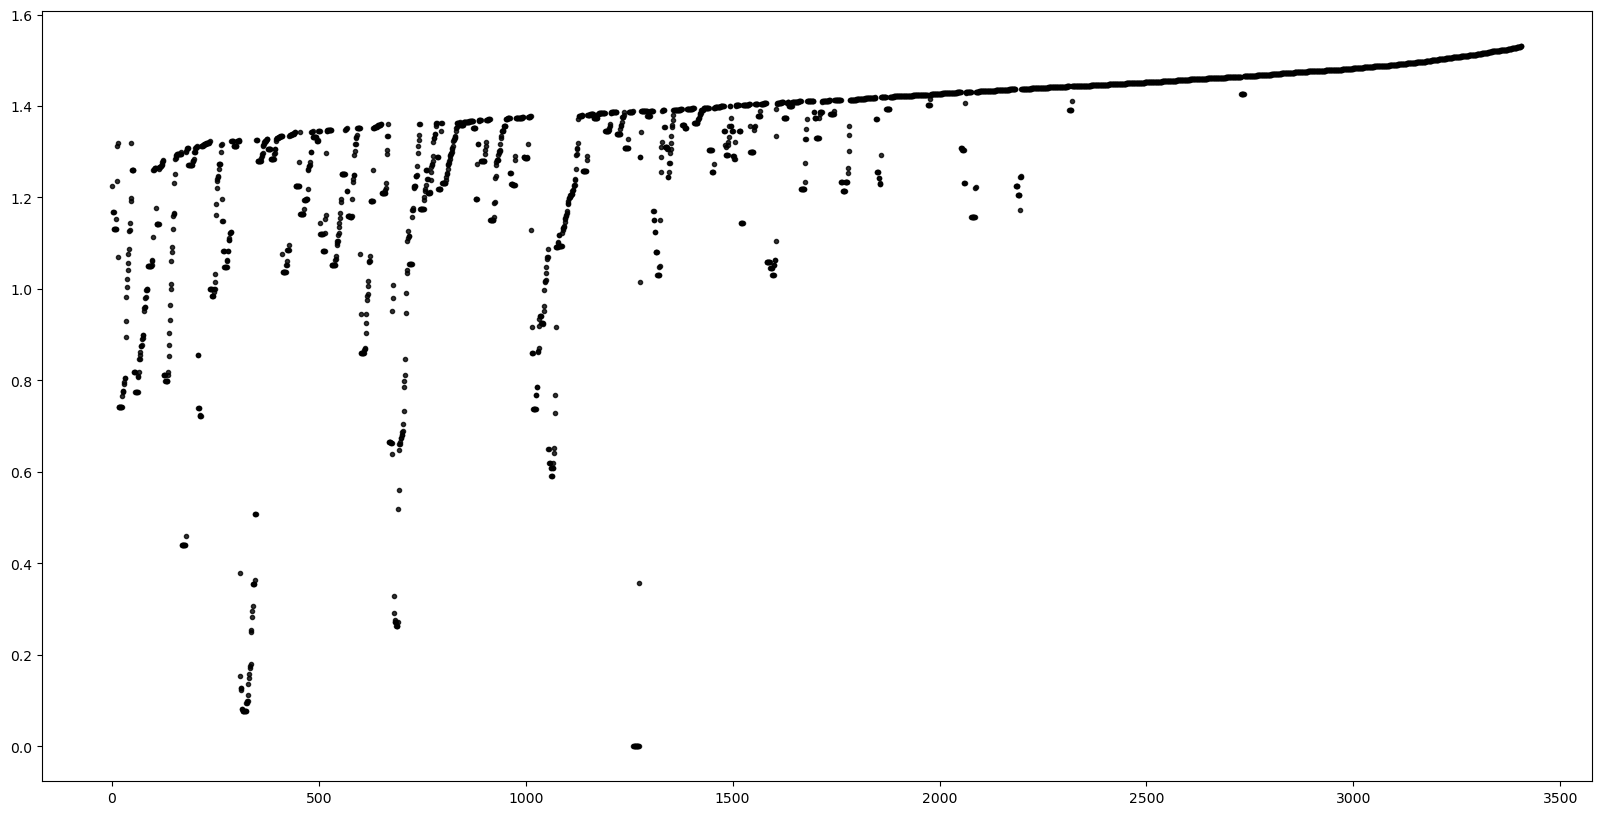

In [332]:
plt.figure(figsize=(20, 10))
G = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(G[0, 0])
ax1.plot(space, reachability, "k.", alpha=0.8)

In [321]:
clust.cluster_hierarchy_

array([[   0,   12],
       [  15,   34],
       [  14,   46],
       [  52,   76],
       [  52,   99],
       [ 124,  150],
       [ 168,  178],
       [ 206,  215],
       [ 236,  250],
       [ 265,  288],
       [ 308,  348],
       [ 411,  428],
       [ 502,  517],
       [ 530,  563],
       [ 599,  631],
       [ 668,  677],
       [ 680,  693],
       [ 680,  711],
       [ 668,  713],
       [ 785,  794],
       [ 961,  975],
       [1013, 1031],
       [1054, 1072],
       [1137, 1148],
       [1259, 1275],
       [1307, 1325],
       [1442, 1454],
       [1581, 1604],
       [1848, 1858],
       [2051, 2061],
       [2076, 2087],
       [2183, 2197],
       [   0, 3406]])

In [322]:
clust.ordering_

array([  0,  13,  39, ...,  35, 194, 164])

In [325]:
for elem in clust.ordering_:
    print("from : ", frame_sub_dedup["from"].values[elem])
    print("subject :", frame_sub_dedup["subject"].values[elem])
    print("snippet :", frame_sub_dedup["snippet"].values[elem])
    print("----"*20)

from :  LinkedIn Job Alerts <jobalerts-noreply@linkedin.com>
subject : 3 new jobs for “quantitative researcher”
snippet : Senior Quantitative Researcher and other roles are available ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏
--------------------------------------------------------------------------------
from :  LinkedIn Job Alerts <jobalerts-noreply@linkedin.com>
subject : 3 new jobs for “data scientist”
snippet : Data Scientist and other roles are available ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏
--------------------------------------------------------------------------------
from :  LinkedIn Job Alerts <jobalerts-noreply@linkedin.com>
subject : 1 new job for “quantitative researcher”
snippet : Quantitative UX Researcher and other roles are available ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏ ͏

Text(0.5, 1.0, 'Reachability Plot')

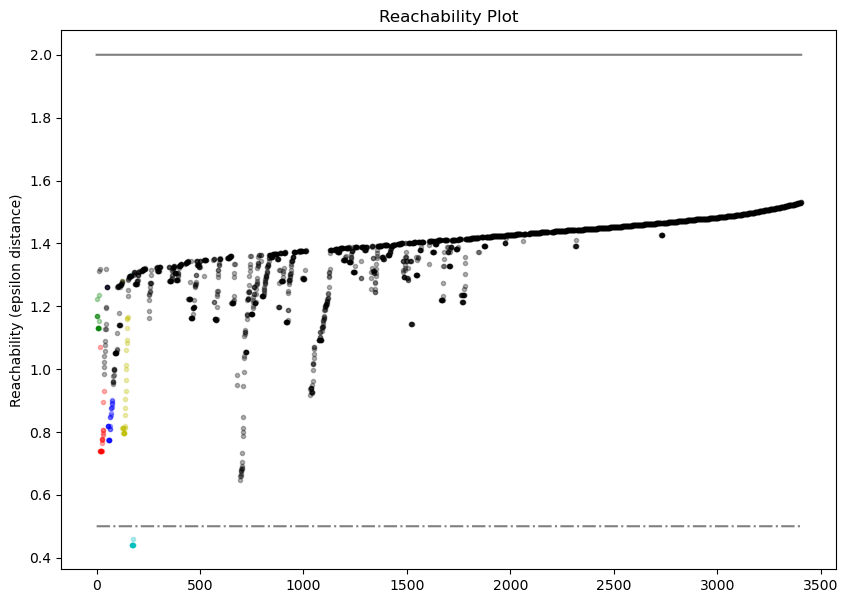

In [315]:
plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(G[0, 0])
# ax2 = plt.subplot(G[1, 0])
# ax3 = plt.subplot(G[1, 1])
# ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")